### Summary
With reference to fastai Deep Learning course lesson 2, we implement the general steps suggested by Jeremy Howard on our dress data project. The general steps are described as follows:
1. Enable data augmentation, and precompute = True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for several epochs
4. Train last later with data augmentation (precompute = False) for another several epochs with cycle_len = 1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult = 2 until over-fitting
9. Apply Test Time Augmentation for Predictions


In [0]:
#Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt

In [0]:
PATH = '/content/selected_gd_data/'
# image size may need to adjust
sz = 224

#### 1. Enable Data  Augementation

In [0]:
arch = resnet34
# flip sideways, vary the contrast, blur, zoom-in
tfms = tfms_from_model(resnet34, 
                       sz, 
                       # transform_top_down: flip vertically
                       # transform_side_on: flip horizontally
                       aug_tfms = transforms_side_on,
                       max_zoom = 1.1)

In [0]:
def get_augs():
  data = ImageClassifierData.from_paths(PATH, 
                                        bs = 2,
                                        trn_name = 'imgtrain',
                                        val_name = 'imgval',
                                        tfms = tfms, 
                                        num_workers = 1)
  x, _ = next(iter(data.aug_dl))
  return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

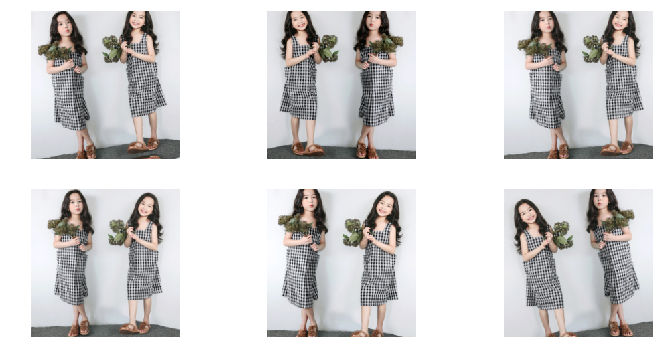

In [0]:
plots(ims, rows = 2)

#### 2. Find Suitable Learning Rate

In [0]:
# Create a new data object with augmented data included
data = ImageClassifierData.from_paths(PATH, 
                                      tfms = tfms,
                                      trn_name = 'imgtrain',
                                      val_name = 'imgval')

# when precompute = True, data augmentation not work
learn = ConvLearner.pretrained(arch, data, precompute = True)

lrf = learn.lr_find(1e-7,1e2)

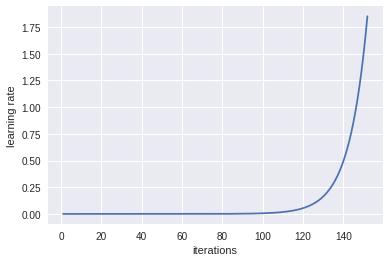

In [0]:
learn.sched.plot_lr()

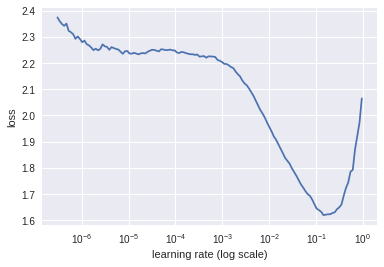

In [0]:
# Find the learning rate with highest decrease in loss function
# From the graph, lr = 0.01 is appropriate
learn.sched.plot()

#### 3. Train Last Layers with Precomputed Activation

In [0]:
# This learning has no data augmentation included
learn.fit(1e-2, 40)

epoch      trn_loss   val_loss   accuracy   
    0      0.94902    0.777539   0.694927  
    1      0.850707   0.722818   0.71028   
    2      0.785583   0.695294   0.726302  
    3      0.772972   0.671503   0.73765   
    4      0.703533   0.65381    0.753004  
    5      0.707456   0.634107   0.751001  
    6      0.656538   0.607043   0.771696  
    7      0.645408   0.604077   0.76502   
    8      0.597332   0.591547   0.771028  
    9      0.598636   0.576615   0.779706  
    10     0.576939   0.566327   0.789052  
    11     0.540235   0.568196   0.785047  
    12     0.522223   0.549136   0.799065  
    13     0.51906    0.542044   0.781041  
    14     0.496963   0.538176   0.787717  
    15     0.483855   0.537859   0.79239   
    16     0.469233   0.531535   0.801736  
    17     0.454656   0.521494   0.807744  
    18     0.445162   0.509573   0.809079  
    19     0.422651   0.508705   0.810414  
    20     0.413783   0.511834   0.805073  
    21     0.397624   0.536281 

[array([0.50143]), 0.8204272366334027]

#### 6. Find Suitable Learning Rate again

In [0]:
lrf = learn.lr_find(1e-40,1e-27)

epoch      trn_loss   val_loss   accuracy   
    0      0.277776   0.487853   0.828438  


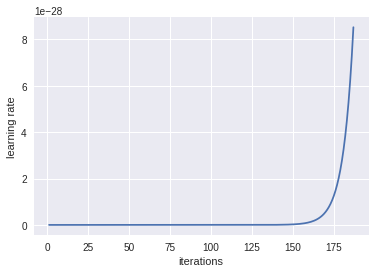

In [0]:
learn.sched.plot_lr()

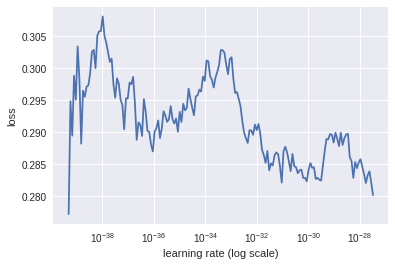

In [0]:
# Optimal learning rate completely change
# lr = 1e-33 seems to be suitable
learn.sched.plot()

#### 5. Train Last Layers with Data Augmentation

In [0]:
# set precompute = False and learn again
# This time augmented data is included
learn.precompute = False

# cycle_len = 1
# [learning rate (cosine) annealing] decrease learning rate with iterations
# reset learning rate to its peak at every epoch
# gradually decrease learning rate for each minibatch
# Note that we are training the last layer (randomly initialized)
learn.fit(1e-33, 20, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.966027   0.751648   0.753672  
    1      0.918622   0.726887   0.757009  
    2      0.967765   0.731339   0.763017  
    3      0.958489   0.719827   0.758344  
    4      0.941561   0.734871   0.748999  
    5      0.973484   0.742077   0.755007  
    6      0.95026    0.716288   0.75968   
    7      0.935534   0.725732   0.755007  
    8      0.987907   0.724917   0.757009  
    9      0.963069   0.721914   0.759012  
    10     0.96117    0.731134   0.759012  
    11     0.979356   0.73291    0.755674  
    12     0.947405   0.710059   0.76502   
    13     0.946853   0.729079   0.761015  
    14     0.946926   0.734184   0.757009  
  0%|          | 0/187 [00:00<?, ?it/s]

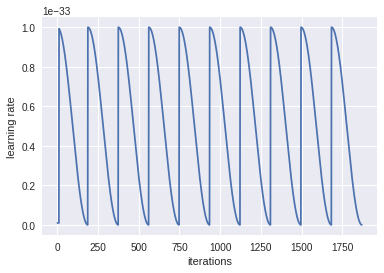

In [0]:
learn.sched.plot_lr()

In [0]:
# save the model
# It is saved in {PATH}/models
learn.save('224_dress_lastlayer')
# load in the model
learn.load('224_dress_lastlayer')

#### 6. Unfreeze All Layers

In [0]:
# unfreeze the remaining layers
# unfreeze layer from n onwards
learn.unfreeze()

#### 7. Find Suitable Learning Rate Again

In [0]:
# Let's see if the optimal learning rate has changed after we trained the un-precomputed last layer
lrf = learn.lr_find(1e-40,1e-20)

epoch      trn_loss   val_loss   accuracy   
    0      0.936066   0.715833   0.761682  


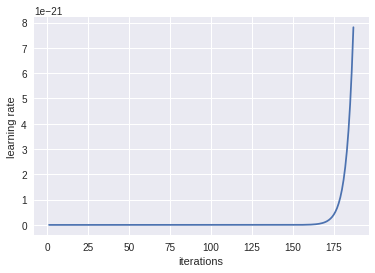

In [0]:
learn.sched.plot_lr()

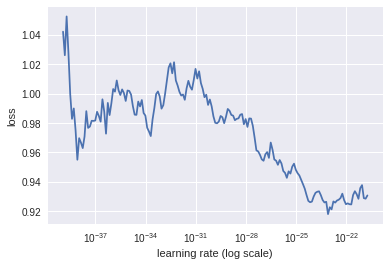

In [0]:
# Find the learning rate with highest decrease in loss function
# From the graph, lr = 1e-25 - 1e-27 is appropriate
learn.sched.plot()

#### 8. Apply Differential Learning Rate

In [0]:
# The most shallow layers need little training
# The deepest layers need more training
# shallow > middle > deep
lr = np.array([1e-27, 1e-26, 1e-25])

In [0]:
# stochastics gradient descent: cycle_len = 1
# number of cycles = 3
# each cycle contains 2 epoch
# cycle_mult = 2 - Double the length of cycle for each cycle
# 1 + 2 + 4 epochs
learn.fit(lr, 5, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.914693   0.729068   0.739653  
    1      0.970085   0.741786   0.733645  
    2      0.915163   0.735371   0.732977  
 64%|██████▎   | 119/187 [03:08<01:30,  1.32s/it, loss=0.922]

KeyboardInterrupt: ignored

#### 9. Analysis of Results
1. Confusion Matrix (with and ithout Test Time Augmentation)
2. Sample Check

In [0]:
!ls

adc.json       lr_plot.png  sample_data       selected_gd_data_5.zip
colab_util.py  __pycache__  selected_gd_data
